# Setup

In [1]:
# see custom-setup-20250225-BUSCC.txt for env initialization

In [2]:
import sys
import os
import glob
from pathlib import Path

# sys.path.append("/content/Speech-Articulatory-Coding/")
sys.path.insert(0,"/content/Speech-Articulatory-Coding/")


In [10]:
package_path = Path("./Speech-Articulatory-Coding/gdtw/gdtw")
sys.path.insert(0, package_path.resolve())
import gdtw

In [13]:
%load_ext autoreload
%autoreload 2
import importlib
# import sparc
from sparc import load_model
import copy
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
from matplotlib.patches import ConnectionPatch
import scipy as sp
from scipy.interpolate import interp1d

import librosa
import textgrid


In [16]:
# IF YOU HAVE NVIDIA GPU: device="cuda", otherwise: device="cpu"
coder = load_model("en", device= "cpu", use_penn=True)
FS_SPARC_CODE = 50


load_model v3


c:\Users\mguillau\AppData\Local\anaconda3\envs\${ENV_NAME}\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mguillau\.cache\huggingface\hub\models--cheoljun95--Speech-Articulatory-Coding. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not

load_model v3


c:\Users\mguillau\AppData\Local\anaconda3\envs\${ENV_NAME}\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mguillau\.cache\huggingface\hub\models--microsoft--wavlm-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fall

Using PENN for pitch tracking.


c:\Users\mguillau\AppData\Local\anaconda3\envs\${ENV_NAME}\lib\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [17]:
# WAVLM2EMA = load_model("feature_extraction", device= "cpu", use_penn=True)
# vars(coder)
coder.inverter.linear_model

Linear(in_features=1024, out_features=12, bias=True)

# Helper functions

In [18]:
hprc_channels = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
mngu_channels = [
    'T3_x', 'T3_y',   # TD → T3
    'T2_x', 'T2_y',   # TB → T2
    'T1_x', 'T1_y',   # TT → T1
    'JAW_x','JAW_y',  # LI → JAW
    'UL_x', 'UL_y',   # UL → UL
    'LL_x', 'LL_y'    # LL → LL
]
hprc2mngu = {
    'LIX': 'JAW_x',
    'LIY': 'JAW_y',
    'ULX': 'UL_x',
    'ULY': 'UL_y',
    'LLX': 'LL_x',
    'LLY': 'LL_y',
    'TTX': 'T1_x',
    'TTY': 'T1_y',
    'TBX': 'T2_x',
    'TBY': 'T2_y',
    'TDX': 'T3_x',
    'TDY': 'T3_y',
}
mngu2hprc = {v: k for k, v in hprc2mngu.items()}
idxs_hprc2mngu = [hprc_channels.index(mngu2hprc[c]) for c in mngu_channels]
idxs_mngu2hprc = [mngu_channels.index(hprc2mngu[c]) for c in hprc_channels]
# [hprc[i] for i in idxs_hprc2mngu]


# # hprc index to mngu index
# idxs_hprc2mngu = [
#     6, 7,   # LIX, LIY → JAW_x, JAW_y
#     8, 9,   # ULX, ULY → UL_x, UL_y
#     10, 11, # LLX, LLY → LL_x, LL_y
#     4, 5,   # TDX, TDY → T1_x, T1_y
#     2, 3,   # TBX, TBY → T2_x, T2_y
#     0, 1    #  TTX, TTY → T3_x, T3_y
# ]

# # mngu index to hprc index
# idxs_mngu2hprc = [
#     6, 7,   # T3_x, T3_y → TTX, TTY
#     8, 9,   # T2_x, T2_y → TBX, TBY
#     10,11,  # T1_x, T1_y → TDX, TDY
#     0, 1,   # JAW_x, JAW_y → LIX, LIY
#     2, 3,   # UL_x, UL_y → ULX, ULY
#     4, 5    # LL_x, LL_y → LLX, LLY
# ]

# # Check forward mapping
# # assert all([hprc[i] == mngu[j].replace("_", "").upper() for i, j in enumerate(idxs_hprc2mngu)])

# # Check reverse mapping
# # assert all([mngu[i] == hprc[j].lower().replace("x", "_x").replace("y", "_y") for i, j in enumerate(idxs_mngu2hprc)])
# [hprc[i] for i in idxs_hprc2mngu]

In [19]:
idxs_tongue = np.array([1, 2, 3, 4, 5, 6]) - 1
idxs_jaw = np.array([7, 8]) - 1
idxs_lips = np.array([9, 10, 11, 12]) - 1
idxs_UL = np.array([9, 10]) - 1
PC = pd.read_csv(f'../PC-12d.csv')
labels_PC = ['T_pc1', 'T_pc2', 'T_pc3', 'T_pc4', 'T_pc5', 'T_pc6', 'J_pc1', 'J_pc2', 'L_pc1', 'L_pc2', 'L_pc3', 'L_pc4']

def m2M(m, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  # m should be (12, ns)

  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL
  
  # # 1d version
  # mask_jawUL = np.ones_like(m)
  # mask_jawUL[np.concat([idxs_jaw, idxs_UL]),:] = 0

  # m_jawtile = np.tile(m[idxs_jaw,:], 6)

  # m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  # M = np.dot(np.linalg.inv(PC), m_jawrel)


  mask_jawUL = np.ones_like(m)
  # print(mask_jawUL)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL]),:] = 0

  m_jawtile = np.tile(m[idxs_jaw,:], [6, 1])

  m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  M = np.dot(np.linalg.inv(PC), m_jawrel)
  assert(M.shape[0]==12)

  return M


def M2m(M, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL

  mask_jawUL = np.ones_like(M)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL]), :] = 0

  m = np.dot(PC, M)
  
  m_jawtile = np.tile(m[idxs_jaw, :], [6, 1])
  m = m + np.multiply(mask_jawUL, m_jawtile)

  # assert(m.flatten().size==12)
  assert(m.shape[0]==12)

  return m


FileNotFoundError: [Errno 2] No such file or directory: '../PC-12d.csv'

In [ ]:
color_code = {"UL":mpl.colors.to_rgb("#EE3A5B"),
              "LL":mpl.colors.to_rgb("#FFD155"),
              "LI":mpl.colors.to_rgb("#959595"),
              "TT":mpl.colors.to_rgb("#43B962"),
              "TB":mpl.colors.to_rgb("#C44B9F"),
              "TD":mpl.colors.to_rgb("#0093B7"),
              "Loudness":mpl.colors.to_rgb("#FB754D"),
              "Pitch":mpl.colors.to_rgb("#FB754D"),}

HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

def plot_art(ax, art, labels=None, gap=5, skip_y=False,color=None, series_name="", alpha=1.0, lw=2, plot_velocity=False, pitch=None, loudness=None, periodicity=None):
    yticks=[]
    ytick_labels=[]
    # labels = reversed["UL","LL", "LI", "TT", "TB", "TD"]
    # chidxs = []
    # HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    # channel_label = HPRC_channel_label
    # for l in labels:
    #     chidxs.append(HPRC_channel_label.index(l+"X"))
    #     chidxs.append(HPRC_channel_label.index(l+"Y"))
    labels = labels.copy() # avoid mutating the object passed 
    if labels is None:
        labels = ['T3', 'T2', 'T1', 'JAW', 'UL', 'LL']
        labels = [l+d for l in labels for d in ["_x", "_y"]]
    if pitch is not None:
        labels.append('pitch')
        art = np.column_stack([art, pitch])
    if loudness is not None:
        labels.append('loudness')    
        art = np.column_stack([art, loudness])
    if periodicity is not None:
            labels.append('periodicity')    
            art = np.column_stack([art, periodicity])
    channel_label = list(labels) # make a copy of labels
    chidxs = np.arange(0, len(channel_label))


    time = np.arange(0, art.shape[0]) / 50
    # print(len(art))
    # print(time)
    for i, ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
        else:
            art_name = ch_label
            if color is None:
                color = color_code[art_name]
        x = art[:,ch_i]
        if i == 0 and series_name:
            ax.plot(time, x - gap * i, color=color, alpha=alpha, lw=lw, label=series_name)
        else:
            ax.plot(time, x - gap * i, color=color, alpha=alpha, lw=lw)

        # ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw, label=series_name)
        if plot_velocity:
            ax.plot(time, 2*np.concatenate(([0], np.diff(x))) - gap*i,color='r',alpha=alpha*0.5,lw=1)

        yticks.append(-gap*i)

    # i = i+1
    # # diffs = np.diff(art, axis=0)
    # # maxdiffs = np.max(diffs, axis = 1)
    # diffs = np.vstack([np.zeros((1, 12)), np.abs(np.diff(art, axis=0))])
    # maxdiffs = np.max(diffs, axis = 1)
    # ax.plot(time, 2*maxdiffs-gap*i,color='r',alpha=alpha*0.5,lw=lw)
    # yticks.append(-gap*i)
    # ytick_labels.append('~max velocity')

    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    # xticks= np.arange(0,len(art),50)
    # xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    # ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    # ax.set_xlim(0,len(art))
    # ax.legend()
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center')
    

    return yticks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from matplotlib.animation import FFMpegWriter
ffmpeg_path = "/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/bin/ffmpeg"
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path



def animate_ema(df_ema, filepath_out, sensor_neutral, colors=None, trail_length=5, interval=50):
    """
    Create an animation of EMA articulators with fading comet trails, synchronized by timestamp.

    Parameters:
    df_ema (DataFrame): DataFrame containing columns ['series', 'time', 'T3_x', 'T3_y', ..., 'LL_x', 'LL_y'].
    filepath_out (str): Path to save the animation (e.g., 'animation.mp4').
    sensor_neutral (list): List of neutral (x,y) positions for sensors.
    colors (dict): Dictionary mapping 'series' values to colors (e.g., {'original':'black', 'perturbed':'red'}).
    trail_length (int): Length of the comet trail.
    interval (int): Interval between frames in milliseconds.
    """

    if colors is None:
        colors = {'original': 'black', 'perturbed': 'red'}

    sensors = ['T3', 'T2', 'T1', 'JAW', 'UL', 'LL']

    # Sort by time and group by 'series'
    df_ema = df_ema.sort_values(by='time')
    groups = df_ema.groupby('series')

    # Get unique sorted time points
    time_points = df_ema['time'].unique()

    fig, ax = plt.subplots(figsize=(6, 6))

    # Setting up plot limits
    padding = 1
    x_cols = [f'{s}_x' for s in sensors]
    y_cols = [f'{s}_y' for s in sensors]

    x_all = df_ema[x_cols].values
    y_all = df_ema[y_cols].values

    ax.set_xlim([-4, 8])
    ax.set_ylim([-6, 4])
    # ax.set_xlim(np.min(x_all) - padding, np.max(x_all) + padding)
    # ax.set_ylim(np.min(y_all) - padding, np.max(y_all) + padding)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('EMA Sensor Motion with Fading Comet Trails')
    ax.grid(True)
    ax.set_aspect('equal')

    scatters_dict = {}
    for series, group in groups:
        color = colors.get(series, 'gray')
        scatters = [ax.scatter([], [], color=color, s=50, alpha=1-(i/trail_length)) for i in range(trail_length)]
        scatters_dict[series] = scatters

    time_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, fontsize=12,
                        verticalalignment='top', horizontalalignment='right')

    def init():
        for scatters in scatters_dict.values():
            for scatter in scatters:
                scatter.set_offsets(np.empty((0, 2)))
        time_text.set_text('')
        return sum(scatters_dict.values(), []) + [time_text]

    def update(frame):
        current_time = time_points[frame]
        artists = []

        for series, group in groups:
            scatters = scatters_dict[series]

            current_group = group[group['time'] <= current_time]

            for trail_idx in range(trail_length):
                idx = -(trail_length - trail_idx)
                if abs(idx) <= len(current_group):
                    pos = current_group.iloc[idx]
                    sensor_positions = np.array([
                        [pos[f'{sensor}_x'], pos[f'{sensor}_y']] for sensor in sensors
                    ]) + sensor_neutral
                    scatters[trail_idx].set_offsets(sensor_positions)
                else:
                    scatters[trail_idx].set_offsets(np.empty((0, 2)))

                artists.append(scatters[trail_idx])

        time_text.set_text(f't={current_time:.2f}')
        artists.append(time_text)

        return artists

    ani = FuncAnimation(fig, update, frames=len(time_points), init_func=init,
                        blit=True, interval=interval)

    # Save animation (mp4 recommended)
    ani.save(filepath_out, writer='ffmpeg')
    plt.close(fig)


# Example usage (assuming df_ema and sensor_neutral are prepared as specified):
# sensor_neutral = np.array([[5.4407711, -0.27898258], [3.9024611, 0.090298139], [2.2748213, -0.49493390],
#                            [0.82840538, -2.8019209], [-1.0039096, -0.083905414], [-0.67326981, -2.5571942]])
# animate_ema(df_ema, 'ema_animation.mp4', sensor_neutral, {'original': 'black', 'perturbed': 'red'})

# Visualize EMA trajectories from wav

In [ ]:
yticks=[]
ytick_labels=[]
labels = ["UL","LL", "LI", "TT", "TB", "TD"]
chidxs = []


In [ ]:
# wav_file  = '../sample_audio/pataka-fast.wav'
wav_file  = '../sample_audio/be2d.wav'
wav_file2  = '../sample_audio/be2d-fran-trim-2.wav'
wav_file3  = '../sample_audio/be2d-chin-trim.wav'

# wav_file  = '/Volumes/Nexus4/DBS/derivatives/sub-DM1033/aec/sub-DM1033_ses-intraop_task-lombard_run-03_recording-directionalmicaec_physio.wav'
# wav_file = '../sample_audio/sub-DM1033_ses-intraop_task-lombard_run-03_directionalmicaec-start-99s.wav'

codes = [coder.encode(f) for f in [wav_file, wav_file2, wav_file3]]
# code = coder.encode(wav_file)
# code2 = coder.encode(wav_file2)

# sound = out['wav']
# ema = out['ema'].squeeze()


        # x = art[:,ch_i]
        # ax.plot(time, np.concatenate(0, np.diff(x))-gap*i,color='r',alpha=alpha*0.5,lw=1)
        # ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw)
# i = i+1
# diffs = np.vstack([np.zeros((1, 12)), np.diff(ema, axis=0)])
# maxdiffs = np.max(ema, axis = 1)
# ax.plot(time[2:-1], maxdiffs-gap*i,color=color,alpha=alpha,lw=lw)
# maxdiffs.shape
# maxdiffs.shape

wav, wav_fs = sf.read(wav_file)
# # wav.size


# {k:v.shape for k, v in codes[1].items()}
# {k:v.shape for k, v in code.items()}


In [ ]:
allacoustics = np.concatenate([c['acoustics_wvlm'] for c in codes], axis=0)
pca = PCA().fit(allacoustics)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

allacoustics_stats = pd.DataFrame({'min': np.amin(allacoustics, axis=0).T,
                                   'max': np.amax(allacoustics, axis=0).T})

In [ ]:
codes[1]['loudness'].shape

In [ ]:
acoustics_wvlm_tranformed = [pca.transform(c['acoustics_wvlm'])[:, 0:12] for c in codes]
for i, c in enumerate(codes):
    c.update({'acoustics_wvlm_transform': acoustics_wvlm_tranformed[i]})
#     c['acoustics_wvlm'] =
# acoustics_wvlm_tranformed[1].shape
# codes[1].keys()

In [ ]:
offset = -100
# c = codes[2]
for c in codes:
    d = c['acoustics_wvlm_transform']
    plt.gca().set_prop_cycle(None)
    for i in range(d.shape[1]):
        plt.plot(d[:, i] + i*offset)

plt.gca().set_yticks([])
plt.gca().set_ylabel('wavLM 1024-to-PCA dimensions')
plt.gca().set_xlabel('Time [sample]')

In [ ]:
fig,ax = plt.subplots(3,1, figsize=(5,10), sharex=True)

ax[0].plot(np.arange(0, wav.size) / wav_fs, wav)

for code in codes:
    plot_art(ax[1], (code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], perturb_ema(code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], (code2['ema']), color='C0', gap=6, alpha=0.5, lw=1)


plt.show()

# Simple encode-decode resynthesis

In [ ]:

(fdir, fname) = os.path.split(files[0])
(fname, fext) = fname.split('.')

code_orig = coder.encode(files[0])
# code_orig.pop('wav', None)
code_orig.keys()

# Load DIVA babbling files

In [ ]:
# encode and resynthesize a whole series of files
# for f in

FS_SPARC_CODE = 50
SPARC_EMA_LABELS = ["ULX", "ULY", "LLX", "LLY",  "LIX", "LIY",  "TTX", "TTY", "TBX", "TBY", "TDX", "TDY"]


In [ ]:

# files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
files = [f for f in files if '20250226' in f ]

for idx_f, f in enumerate(files):
# f = files[0]
    print(idx_f, f)
    # if idx_f<500: % 500 files were run 20250225
    #   continue

    (fdir, fname) = os.path.split(f)
    (fname, fext) = fname.split('.')
    if os.path.exists(dir_out + fname + '-resynth-ema.csv'):
        continue

    code_orig = coder.encode(f)
    code_orig.pop('wav', None)


    # write EMA
    code = code_orig['ema'].squeeze()
    code_time = np.arange(1, code.shape[0]+1)  / FS_SPARC_CODE

    df = pd.DataFrame(code)
    df.columns = SPARC_EMA_LABELS
    df['file_id'] = fname
    df['time'] = code_time
    df.to_csv(dir_out + fname + '-resynth-ema.csv', index=False)

    # write wavLM features
    code = code_orig['acoustics_wvlm'].squeeze()
    code_time = np.arange(1, code.shape[0]+1)  / FS_SPARC_CODE
    nfeat = code.shape[1]

    df = pd.DataFrame(code)
    df.columns = ["wavlm_"+str(i) for i in range(0, nfeat)]
    df['file_id'] = fname
    df['time'] = code_time
    df.to_csv(dir_out + fname + '-resynth-wavlm.csv', index=False)

    # write wav file
    wav = coder.decode(**code_orig)
    sf.write(dir_out + fname + '-resynth.wav', wav, coder.sr)

    # write full pickle file
    with open(dir_out + fname + '-resynth.pickle', 'wb') as handle:
            pickle.dump(code_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Learn the matrix W from prior samples

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler


files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
# files = [f for f in files if '202502' in f ]
print(f'n files: {len(files)}')

data_all = []
# Create an SGD-based OLS model
# model = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.0001, verbose=1, warm_start=True)
# model = LinearRegression()
# model = MultiOutputRegressor(model, n_jobs=-1)

# score = np.zeros([13, 1])
# score[:] = np.nan
score = []
ibatch = 0

for idx_f, f in enumerate(files):

  # if not (idx_f>=0 and idx_f<=251):
  #   continue
  # f = files[0]
  print(idx_f, f)

  (fdir, fname) = os.path.split(f)
  (fname, fext) = fname.split('.')

  diva = pd.read_csv(fdir + "/" + fname + '.csv')

  fname_wavlm = dir_out + fname + '-resynth-wavlm.csv'
  if not os.path.exists(fname_wavlm):
      continue
  wavlm = pd.read_csv(fname_wavlm)

  diva_interp = pd.DataFrame({'time': wavlm['time']})  # Keep B's time vector


  id_cols = ['time', 'file_id']
  for col in diva.columns:
      if col in id_cols:  # Skip 'time' column
          continue
      diva_interp[col] = np.interp(wavlm['time'], diva['time'], diva[col])

  # Merge interpolated A with B
  df_merged = pd.merge(wavlm, diva_interp, how='inner', on='time')
  cols = id_cols + [col for col in df_merged.columns if col not in id_cols]
  df_merged = df_merged[cols]

  data_all.append(df_merged)

  # RUN LEAST SQUARES OR SGD-OLS
  if np.mod(len(data_all), 30)==0:
    print(f'Batch update: {ibatch}')
    df_data_all = pd.concat(data_all, ignore_index=True, axis=0)

    cols_wavlm  = [col for col in df_data_all.columns if 'wavlm' in col]
    cols_diva = [col for col in df_data_all.columns if col not in cols_wavlm+id_cols]

    X = df_data_all[cols_wavlm]
    Y = df_data_all[[col for col in cols_diva if col not in ["Tension", "Pressure", "Voicing"]]]

    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Scale features
    # X = scaler_X.fit_transform(X)
    # Y = scaler_Y.fit_transform(Y)

    if ibatch==0:
      print('Batch 0: fitting with OLS then SGD')

      ols = LinearRegression()
      ols.fit(X, Y)
      # Initialize SGD
      base_sgd = SGDRegressor(max_iter=1000, tol=1e-3, warm_start=True, eta0=0.0001)
      model = MultiOutputRegressor(base_sgd, n_jobs=-1)

      # model = LinearRegression()
      model.fit(X, Y)

      # # Initialize SGD with warm_start=True
      # # Manually set coef_ and intercept_ for each output target
      # for i, est in enumerate(model.estimators_ if hasattr(model, 'estimators_') else []):
      #     est.coef_ = ols.coef_[i]  # Set the coefficient vector
      #     est.intercept_ = ols.intercept_[i]  # Set the intercept

      # model.fit(X, Y, coef_init=ols.coef_.copy(), intercept_init=ols.intercept_.copy())
      # model.fit(X, Y)

    else:
      print('Batch >0: fitting with SGD')
      model.partial_fit(X, Y) # if ibatch>=1 else
      # model.fit(X, Y) # Train incrementally
      # model.coef_ = (model.coef_ + model_last.coef_) / 2
      # model.intercept_ = (model.intercept_ + model_last.intercept_) / 2

    # model.fit(X, Y)  # Train incrementally
    # score[0, ibatch] = model.score(X, Y)

    Y_pred = model.predict(X)

    resSS = ((Y - Y_pred)** 2).sum(axis=0)
    ySS = ((Y - Y.mean(axis=0)) ** 2).sum(axis=0)
    r2 = 1 - np.divide(resSS, ySS)
    r2['ns'] = X.shape[0]

    score.append(r2)
    # score = pd.concat([score, r2], ignore_index=True, axis=0)

    del data_all
    data_all = []
    ibatch += 1
    model_last = model

  # out = np.linalg.lstsq(df_merged[cols_wavlm], df_data_all[cols_diva])


  # # verify that interpolation is correct d
  # fig, ax = plt.subplots(2, 1)
  # ax[0].plot(df_merged['time'], df_merged['Jaw'])
  # ax[0].plot(df_merged['time'], df_merged['Jaw']+0.05, alpha=0.5)

# df_data_all = pd.concat(data_all, ignore_index=True, axis=0)



In [ ]:
score = pd.DataFrame(score)
score

In [ ]:
plt.plot(score[[c for c in score.columns if c not in ['ns']]])

In [ ]:
df_merged

In [ ]:
# save data to disk
# df_data_all['file_id'].nunique()
# df_data_all.to_csv(dir_out + 'df_data_all_wavlm-and-divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)



In [ ]:
# cols_wavlm  = [col for col in df_data_all.columns if 'wavlm' in col]
# cols_diva = [col for col in df_data_all.columns if col not in cols_wavlm+id_cols]
# out = np.linalg.lstsq(df_data_all[cols_wavlm], df_data_all[cols_diva])

# when using MultiOutput + SGD
W = [m.coef_ for m in model.estimators_]
W = np.vstack(W)

b = [m.intercept_ for m in model.estimators_]
b = np.concat(b)
b = pd.DataFrame({'b': b})

# # when using MultiOutput + SGD
# W = model.coef_
# b = pd.DataFrame({'b': model.intercept_})

# save values to disk
pd.DataFrame.from_records(W).to_csv(dir_out + 'W_wavlm2divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)
pd.DataFrame.from_records(b).to_csv(dir_out + 'Wb_wavlm2divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)

In [ ]:
W = [m.coef_ for m in model.estimators_]
W = np.vstack(W).shape

b = [m.intercept_ for m in model.estimators_]
b = np.concat(b)
b = pd.DataFrame({'b': b})



# Visualize trajectories of Y_pred

In [ ]:
df_data_all

In [ ]:
W = pd.read_csv(f'{topdir}/sample_audio/diva_babbling_resynth/W_wavlm2divaart-202502261732.csv')
b = pd.read_csv(f'{topdir}/sample_audio/diva_babbling_resynth/Wb_wavlm2divaart-202502261732.csv')
W = W.iloc[:, 1:].values
b = b.iloc[:, 1].values
# # alternatively, W and b from model if it was run
# W = model.coef_
# b = model.intercept_

# print(df_data_all[cols_wavlm].shape)
# print(W.T.shape)
# Y_pred = df_data_all[cols_wavlm] @ W.T + b

# alternatively
# Y_pred = model.predict(X)
print(W.shape)
print(b.shape)


In [ ]:

df_pred = pd.DataFrame.from_records(Y_pred)
df_pred.columns = [s+"_pred" for s in cols_diva]
df_data_all = pd.concat([df_data_all, df_pred], axis=1)

In [ ]:
df_data_all

In [ ]:
# calculate sum of squares prediction value for each articulator
r2 = {}
for i, col in enumerate(cols_diva):
    # col = "Jaw"
    # corr = np.dot(df_data_all[col], df_data_all[col+"_pred"])
    res = df_data_all[col+"_pred"] - df_data_all[col]
    r2[col] = 1 - ((res**2).sum()) / (df_data_all[col]**2).sum()
    r2[col] = float(np.round(r2[col], 2))
# np.corrcoef(df_data_all[col+"_pred"], df_data_all[col])
r2

In [ ]:
fileex = 'diva_babbling-20250224123835338'
df_plot = df_data_all[df_data_all['file_id']==fileex]

fig, ax = plt.subplots(figsize=[12, 10])
cm = np.asarray(mpl.colormaps['tab10'].colors)
offset = 1.5
for iart,art_name in enumerate(cols_diva):
    cur_offset = iart*offset
    ax.plot(df_plot['time'], cur_offset + df_plot[art_name],         color=cm[iart % cm.shape[0], :], alpha=0.5)
    ax.plot(df_plot['time'], cur_offset + df_plot[art_name+"_pred"], color=cm[iart % cm.shape[0], :], linestyle='--')

ax.set_yticks(offset*np.arange(len(cols_diva)), [c + " (r2=" + str(round(r2[c], 2)) + ")" for c in cols_diva] )
plt.show()

# Convert test wav file to diva art time series using learned W

In [ ]:
wav_file = f'{topdir}/sample_audio/eeayeeayoo.wav'
# wav_file = '../sample_audio/thisisme-lat.wav'

(fdir, fname) = os.path.split(wav_file)
(fname, fext) = fname.split('.')

In [ ]:

code_orig = coder.encode(wav_file)


In [ ]:
# code_orig
wavlm  = code_orig['acoustics_wvlm']
divaart_predic = wavlm @ W.T + b
pd.DataFrame.from_records(divaart_predic).to_csv(fdir + "/" +  fname + '-divaart-predic-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=False)

# Encode, resynthesize, perturb wav file

In [ ]:
vars_timeseries = ['ema', 'loudness', 'pitch', 'periodicity']
# wav_file = '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav'
code_orig = coder.encode(wav_file)
# code_orig = {k : v.squeeze().shape for k, v in code_orig.items() if k in ['ema', 'loudness', 'pitch', 'periodicity']}
# code_orig =

code_orig = {k: (v.squeeze(axis=0) if k in vars_timeseries+["spk_emb"] and v.shape[0]==1 else v) for k, v in code_orig.items()}
# {k : (v.shape if k in ['ema', 'loudness', 'pitch', 'periodicity', 'acoustics_wvlm', 'spk_emb'] else v) for k,v in code_orig.items()}


### Plot the SPARC linear transform from auditory to motor space

In [ ]:
W = coder.inverter.linear_model.weight.float().numpy()
B = coder.inverter.linear_model.bias.float().numpy()
fig, ax = plt.subplots(figsize=[20, 10])
ax.imshow(W[:, 100:200])
W.shape

In [ ]:
wav = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth.wav', wav, coder.sr)

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
def perturb_ema(ema):
    pert = np.zeros_like(ema)
    pert_t = np.arange(0, pert.shape[0]) / 50

    t_pert_start = 0.3
    t_pert_end = 1.2

    idxs_x = [s in ['TBX', 'TDX'] for i,s in enumerate(HPRC_channel_label)]
    idxs_y = [s in ['TBY', 'TDY'] for i,s in enumerate(HPRC_channel_label)]

    idxs_t = (pert_t>t_pert_start) & (pert_t<t_pert_end)

    # pert[idxs_t, idxs_x] = 0.1
    pert[np.ix_(idxs_t, idxs_x)] = 0.5
    pert[np.ix_(idxs_t, idxs_y)] = 1

    # pert = [ for i in range(pert.shape[1])]
    pert = np.apply_along_axis(lambda x : sp.signal.savgol_filter(x, 5, 2), axis=0, arr=pert)

    # plt.imshow(pert)
    # np.max(ema, axis=0)
    return ema + pert

In [ ]:
code = copy.deepcopy(code_orig)
# code = code_orig.copy()

code['ema'] = perturb_ema(code_orig['ema'])
wav = coder.decode(**code)
sf.write(wav_file[0:-4] + '-resynth-pert.wav', wav, coder.sr)

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# extend the perturbation
code = copy.deepcopy(code_orig)

idx_split = 44
def extendmat(m, idx_split, nrpt, axis=0):
    return np.concatenate((m[0:idx_split, :], np.tile(m[idx_split, :], (nrpt, 1)), m[idx_split:-1, :]), axis=axis)

code =  {k: (extendmat(v, idx_split, 100) if k in ['ema', 'loudness', 'pitch', 'periodicity'] else v) for k, v in code.items()}
# {k: extendmat(v, idx_split, 20) for k, v in code.items()}
# {k: (v.shape if k in vars_timeseries else 1) for k, v in code.items()}

wav = coder.decode(**code)
sf.write(wav_file[0:-4] + '-resynth-extended.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# test the minimal amount of data we can pass to the synthesizer
code = copy.deepcopy(code_orig)

idx_width = 1
idx_center = 40
def slicemat(m, idx_width, idx_center):
    idxs = np.arange(idx_width) + idx_center
    return m[idxs, :]

code =  {k: (slicemat(v, idx_width, idx_center) if k in ['ema', 'loudness', 'pitch', 'periodicity'] else v) for k, v in code.items()}
# {k: extendmat(v, idx_split, 20) for k, v in code.items()}
# {k: (v.shape if k in vars_timeseries else 1) for k, v in code.items()}


In [ ]:

wav = coder.decode(**code)
print(f'Duration: {len(wav) / coder.sr}')
sf.write(wav_file[0:-4] + '-sliced.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

# Detect audio errors from bed to bad, apply to motor command

In [ ]:
vars_timeseries = ['ema', 'loudness', 'pitch', 'periodicity']

wav_file_bed  = '../sample_audio/bed-lat.wav'
wav_file_bAd  = '../sample_audio/bad-lat.wav'

# trim wav files to make them equal length
wav_bed,wav_bed_sr = sf.read(wav_file_bed)
wav_bAd,wav_bAd_sr = sf.read(wav_file_bAd)

if len(wav_bed)>len(wav_bAd):
    wav_bed = wav_bed[0:len(wav_bAd)]
else:
    wav_bAd = wav_bAd[0:len(wav_bed)]

print(len(wav_bed), len(wav_bAd))
sf.write(wav_file_bed[0:-4] + '-trim.wav', wav_bed, wav_bed_sr)
sf.write(wav_file_bAd[0:-4] + '-trim.wav', wav_bAd, wav_bed_sr)


In [ ]:
wav_file_bed  = '../sample_audio/bed-lat-trim.wav'
wav_file_bAd  = '../sample_audio/bad-lat-trim.wav'

def squeeze_code(code_orig):
    return {k: (v.squeeze(axis=0) if k in vars_timeseries+["spk_emb"] and v.shape[0]==1 else v) for k, v in code_orig.items()}

codes = [coder.encode(f) for f in [wav_file_bed, wav_file_bAd]]
codes = [squeeze_code(c) for c in codes]


In [ ]:
# get error traces
W = coder.inverter.linear_model.weight.float().numpy()
B = coder.inverter.linear_model.bias.float().numpy()

A_error = codes[1]['acoustics_wvlm'] - codes[0]['acoustics_wvlm']
M_error = np.dot(A_error, W.T) + B
M_error = M_error


In [ ]:
code_new = copy.deepcopy(codes[0])
code_new['ema'] = codes[0]['ema'] + M_error

codes.append(code_new)

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(5,10), sharex=True)

ax[0].plot(np.arange(0, wav_bed.size) / sr, wav_bed)

for code, color in zip(codes, ['tab:red', 'tab:blue','tab:purple']):
    print(color)
    plot_art(ax[1], (code['ema']), color=color, gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], perturb_ema(code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], (code2['ema']), color='C0', gap=6, alpha=0.5, lw=1)


plt.show()

In [ ]:
wavs_resynth = [coder.decode(**c) for c in codes]

sf.write(wav_file_bed[0:-4] + '-resynth.wav', wavs_resynth[0], coder.sr)
sf.write(wav_file_bAd[0:-4] + '-resynth.wav', wavs_resynth[1], coder.sr)
sf.write(wav_file_bed[0:-4] + '-pert-towards-bad-resynth.wav', wavs_resynth[2], coder.sr)


In [ ]:
# listen to all three:
ipd.display(ipd.Audio(wavs_resynth[0], rate=coder.sr))
ipd.display(ipd.Audio(wavs_resynth[1], rate=coder.sr))
ipd.display(ipd.Audio(wavs_resynth[2], rate=coder.sr))




# Use PC decomposition to perturb motor trajectories

In [ ]:
# files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
topdir = '/projectnb/busplab/lbullock/sparc_sample_audio' # for BU SCC
# topdir = '/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding'
# files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
# files = glob.glob(f'{topdir}/sample_audio/eeayeeayoo.wav')
files = glob.glob(f'{topdir}/sample_audio/p*k_aligned.wav')

# dir_out = '../sample_audio/diva_babbling_resynth_20250224/'
# dir_out = '/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/sample_audio/diva_babbling_resynth_20250224/'
dir_out = (f'{topdir}/sample_audio/diva_babbling_resynth/')

files[0:10]


['/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pAHk_aligned.wav',
 '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pUWk_aligned.wav',
 '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pEHk_aligned.wav',
 '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pIYk_aligned.wav']

In [ ]:
hprc_channels = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
mngu_channels = [
    'T3_x', 'T3_y',   # TD → T3
    'T2_x', 'T2_y',   # TB → T2
    'T1_x', 'T1_y',   # TT → T1
    'JAW_x','JAW_y',  # LI → JAW
    'UL_x', 'UL_y',   # UL → UL
    'LL_x', 'LL_y'    # LL → LL
]
hprc2mngu = {
    'LIX': 'JAW_x',
    'LIY': 'JAW_y',
    'ULX': 'UL_x',
    'ULY': 'UL_y',
    'LLX': 'LL_x',
    'LLY': 'LL_y',
    'TTX': 'T1_x',
    'TTY': 'T1_y',
    'TBX': 'T2_x',
    'TBY': 'T2_y',
    'TDX': 'T3_x',
    'TDY': 'T3_y',
}
mngu2hprc = {v: k for k, v in hprc2mngu.items()}
idxs_hprc2mngu = [hprc_channels.index(mngu2hprc[c]) for c in mngu_channels]
idxs_mngu2hprc = [mngu_channels.index(hprc2mngu[c]) for c in hprc_channels]
# [hprc[i] for i in idxs_hprc2mngu]



# # hprc index to mngu index
# idxs_hprc2mngu = [
#     6, 7,   # LIX, LIY → JAW_x, JAW_y
#     8, 9,   # ULX, ULY → UL_x, UL_y
#     10, 11, # LLX, LLY → LL_x, LL_y
#     4, 5,   # TDX, TDY → T1_x, T1_y
#     2, 3,   # TBX, TBY → T2_x, T2_y
#     0, 1    #  TTX, TTY → T3_x, T3_y
# ]

# # mngu index to hprc index
# idxs_mngu2hprc = [
#     6, 7,   # T3_x, T3_y → TTX, TTY
#     8, 9,   # T2_x, T2_y → TBX, TBY
#     10,11,  # T1_x, T1_y → TDX, TDY
#     0, 1,   # JAW_x, JAW_y → LIX, LIY
#     2, 3,   # UL_x, UL_y → ULX, ULY
#     4, 5    # LL_x, LL_y → LLX, LLY
# ]

# # Check forward mapping
# # assert all([hprc[i] == mngu[j].replace("_", "").upper() for i, j in enumerate(idxs_hprc2mngu)])

# # Check reverse mapping
# # assert all([mngu[i] == hprc[j].lower().replace("x", "_x").replace("y", "_y") for i, j in enumerate(idxs_mngu2hprc)])
# [hprc[i] for i in idxs_hprc2mngu]



In [ ]:

# M = np.array([0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0])
# M = np.zeros_li?e(ema, )

# ema = np.squeeze(code_orig['ema'])
# ema_pert_M = np.zeros_like(ema)
# ema_pert_M[[60], idxs_jaw[0]] = 0.5
# ema_pert_M[[120], idxs_jaw[0]] = -0.5

# ema_pert_M.shape

# ema_pert_M[:, idxs_jaw[0]] = np.convolve(np.hanning(100), ema_pert_M[:, idxs_jaw[0]], 'same')

# # M[idxs_jaw[0]] = 0.5

# # M2m(M, PC)

# plt.imshow(ema_pert_M.T)
# plt.imshow(M2m(ema_pert_M.T, PC))




In [ ]:
ema_pert_mngu = M2m(ema_pert_M.T, PC).T
ema_pert_hprc = ema_pert_mngu[:, idxs_mngu2hprc]

fig, ax = plt.subplots(figsize=[12, 5])
im = ax.pcolor(ema_pert_hprc.T)
ax.set_yticks(np.arange(0.5, len(hprc_channels), 1), (hprc_channels))
fig.colorbar(im, ax=ax)

np.expand_dims(ema_pert_hprc, axis=0).shape


In [ ]:
# TESTING
wav_file = files[3]

code_orig = coder.encode(wav_file)
print(code_orig['acoustics_wvlm'].shape)
print(code_orig['ema'].shape)

wav = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth.wav', wav, coder.sr)


_extract_ema: v4
(120, 1024)
(1, 120, 12)


In [ ]:

code_orig['ema'] = np.expand_dims(ema_pert_hprc, axis=0)
wav_pert = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth-pert.wav', wav_pert, coder.sr)

# ground truth
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

# resynthesized--pert
ipd.display(ipd.Audio(wav_pert, rate=coder.sr))




# Interopolate between EMA pIYk, pUWk

In [ ]:
# files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
topdir = '/projectnb/busplab/lbullock/sparc_sample_audio' # for BU SCC
# topdir = '/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding'
# files = glob.glob(f'{topdir}/sample_audio/diva_babbling/diva_babbling*.wav')
# files = glob.glob(f'{topdir}/sample_audio/eeayeeayoo.wav')
files = glob.glob(f'{topdir}/sample_audio/p*k_aligned.wav')

# dir_out = '../sample_audio/diva_babbling_resynth_20250224/'
# dir_out = '/content/drive/MyDrive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/sample_audio/diva_babbling_resynth_20250224/'
dir_out = (f'{topdir}/sample_audio/diva_babbling_resynth/')

files[0:10]


['/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pAHk_aligned.wav',
 '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pUWk_aligned.wav',
 '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pEHk_aligned.wav',
 '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pIYk_aligned.wav']

In [ ]:
codes = [coder.encode(f) for f in files]

/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4


In [ ]:
for code in codes:
    [print(k, code[k].shape) for k in code.keys() if k in ['ema', 'acoustic_wvlm', 'pitch', 'periodicity', 'loudness']]

ema (1, 128, 12)
loudness (1, 129, 1)
pitch (1, 128, 1)
periodicity (1, 128, 1)
ema (1, 127, 12)
loudness (1, 128, 1)
pitch (1, 127, 1)
periodicity (1, 127, 1)
ema (1, 126, 12)
loudness (1, 127, 1)
pitch (1, 126, 1)
periodicity (1, 126, 1)
ema (1, 120, 12)
loudness (1, 121, 1)
pitch (1, 120, 1)
periodicity (1, 120, 1)


In [ ]:
target = copy.deepcopy(c)
target.keys()

dict_keys(['code_orig', 'fname', 'loudness', 'ema', 'pitch', 'periodicity', 'time', 'wav', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time', 'warped'])

In [ ]:
print(c["warped"].keys())

dict_keys(['phi', 'time', 'loudness', 'ema', 'pitch', 'periodicity', 'mfcc_time', 'mfcc', 'mfcc_delta', 'specgram_time', 'specgram'])


In [ ]:
print()
# testing
print(c['code_orig'].keys())
print(target.keys())
mkeys = ['ema', 'acoustic_wvlm', 'pitch', 'periodicity', 'loudness', 'time', 'mfcc', 'mfcc_delta']
[print(k, target[k].shape) for k in target.keys() if k in mkeys]

print()
[print(k, c[k].shape) for k in c.keys() if k in mkeys]

print()
[print(k, c["code_orig"][k].shape) for k in c["code_orig"].keys() if k in mkeys]




dict_keys(['wav', 'ema', 'acoustics_wvlm', 'loudness', 'pitch', 'periodicity', 'pitch_stats', 'spk_emb', 'ft_len'])
dict_keys(['code_orig', 'fname', 'loudness', 'ema', 'pitch', 'periodicity', 'time', 'wav', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time', 'warped'])
loudness (182,)
ema (182, 12)
pitch (182,)
periodicity (182,)
time (182,)
mfcc (314, 13)
mfcc_delta (314, 13)

loudness (189,)
ema (189, 12)
pitch (189,)
periodicity (189,)
time (189,)
mfcc (325, 13)
mfcc_delta (325, 13)

ema (1, 187, 12)
loudness (1, 189, 1)
pitch (1, 188, 1)
periodicity (1, 188, 1)


[None, None, None, None]

In [ ]:

loudnesses_orig = [np.squeeze(c['loudness']) for c in codes]

loudnesses_orig = [np.squeeze(c['loudness']) for c in codes]
emas_orig = [np.squeeze(c['ema']) for c in codes]
pitches_orig = [np.squeeze(c['pitch']) for c in codes]

loudnesses_orig = [l[:-1] for l in loudnesses_orig]
# loudnesses_orig[1].shape

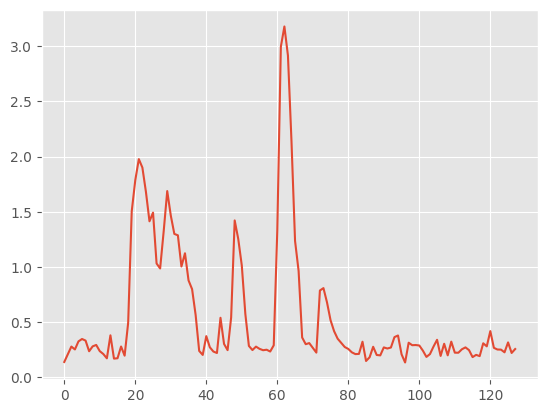

In [ ]:
# plt.plot(loudness_orig[0])
plt.plot(loudnesses_orig[1])

In [ ]:
emas_orig = [np.squeeze(c['ema']) for c in codes]
# emas_orig = emas_orig + [ema_pert]

# # maxlen = max([e.shape[0] for e in emas_orig])
# maxlen = 250 # be generous with padding
# emas = [
#     np.pad(e, ((0, maxlen - e.shape[0]), (0, 0)), mode='constant')
#     for e in emas_orig
# ]
# emas = [m2M(m.T, PC).T for m in emas] # convert to PC space

# [e.shape for e in emas]
emas_orig_time = [np.arange(1, e.shape[0]+1) / FS_SPARC_CODE for e in emas_orig]
# emas_time[0]

In [ ]:
# Test: ensure invertibility of m to M (PC space) and back to m
emas_orig[0].shape

m = emas_orig[0][10:12,:].T
M = m2M(m, PC)


# print(m)
# print(M2m(M, PC))
# pd.DataFrame({'m_orig': m, 'm_recon': M2m(M, PC)})
# mnew = M2m(M, PC)

df_M = pd.DataFrame(emas_orig[0])
df_M.columns = labels_PC
df_M


,T_pc1,T_pc2,T_pc3,T_pc4,T_pc5,T_pc6,J_pc1,J_pc2,L_pc1,L_pc2,L_pc3,L_pc4
0,-0.471538,0.006726,-0.797926,0.345838,-0.998552,-0.167733,-0.154163,0.055580,0.210839,0.221292,0.006644,0.177621
1,0.011366,-0.204018,-0.262736,0.097698,-0.538812,-0.269612,0.073127,0.015033,0.241966,-0.025310,0.315640,-0.109865
2,0.326626,-0.253679,0.084894,-0.007363,-0.220361,-0.338639,0.213063,0.001782,0.129899,-0.262834,0.419735,-0.203005
3,0.385437,-0.155526,0.156030,0.038032,-0.129559,-0.343119,0.292941,-0.002873,-0.067630,-0.418922,0.357297,-0.114422
4,0.227294,-0.057086,0.004477,0.123093,-0.249975,-0.274541,0.399150,-0.036619,-0.166976,-0.439311,0.330987,-0.019778
...,...,...,...,...,...,...,...,...,...,...,...,...
123,1.053021,-0.182932,0.739488,-0.023306,0.417674,-0.132125,0.026428,0.602228,0.265643,-0.055328,-0.008517,0.596359
124,1.204038,-0.483604,1.062244,-0.366189,0.644027,-0.133699,-0.119183,0.593838,0.121067,0.029554,-0.173062,0.588084
125,1.122935,-0.658575,1.096243,-0.577339,0.640734,-0.175536,-0.183047,0.423010,-0.088379,0.003731,-0.290932,0.415823
126,0.663984,-0.410140,0.587059,-0.379864,0.245132,-0.250390,-0.128521,0.135793,-0.151288,-0.081913,-0.251999,0.155044


In [ ]:
# extract vowel PC representations
vowels = ["pAHk", "pEHk", "pUWk", "pIYk"]
vowel_time = [1.3, 1.5]
vowels_pc = {}

for iv, v in enumerate(vowels): 
    f1_idx = next(i for i, s in enumerate(files) if v in s) 
    
    idxs = [np.argmin(abs(emas_orig_time[f1_idx] - t)) for t in vowel_time]
    pc_alltimes = emas_orig[f1_idx][idxs[0]:idxs[1], :]
    vowels_pc[v] = np.mean(pc_alltimes, axis=0).reshape([12,1])

# vowels_pc['pAHk'].shape
# emas_orig[f1_idx].shape

viapts = np.concat([vowels_pc['pIYk'], vowels_pc['pUWk'], vowels_pc['pAHk'], vowels_pc['pEHk']], axis=1)
viapts = np.concat([viapts, viapts], axis=1)

viapts = np.concat([np.zeros([viapts.shape[0], 2]),  viapts, np.zeros([viapts.shape[0], 2])], axis=1)
#  = [0 0.4 0.8 1.2 1.6 2.0 2.4]
timepts = 0.5 + np.arange(8) * 0.3 # 
timepts = np.concatenate([[0, timepts[0]-0.3],timepts,[timepts[-1]+0.3, 5]])

# timepts.shape viapts.shape


from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from scipy.interpolate import interp1d

spl = [PchipInterpolator(timepts, viapts[i, :]) for i in range(viapts.shape[0])]
# timepts_sample = 1.2 + np.arange(0, timepts[-1], 1/FS_SPARC_CODE)
timepts_sample = np.arange(0, 5, 1/FS_SPARC_CODE)
# timepts_sample.shape

aroundtown = {}
aroundtown['M'] = np.vstack([spl[i](timepts_sample) for i in range(viapts.shape[0])]).T
aroundtown['t'] = timepts_sample
aroundtown['m'] = M2m(aroundtown['M'].T, PC).T



In [ ]:
viapts.shape

(12, 12)

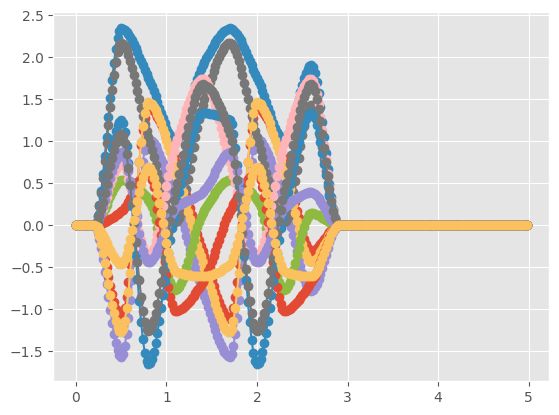

In [ ]:
# plt.plot(timepts, viapts.T, "-o")
plt.plot(aroundtown['t'], aroundtown['M'], "-o")

In [ ]:
alpha = 1 # how much of the  (1-alpha) first alpha vs second (alpha)? 

w1 = "pIYk" # pIYk, be2d
f1_idx = next(i for i, s in enumerate(files) if w1 in s)

# w2 = "pUWk" # pUWk
# f2_idx = next(i for i, s in enumerate(files) if w2 in s)



# # set the perturbation manually 
# f2_idx = len(emas)
# w2 = "M7_pert-sz-5" # _M7_pert-sz-5"
# # attempt to create a timeseries of perturbation
# M = np.zeros([12, 1])
# # M[2] = 5
# M[6] = 5
# m_pert = M2m(M, PC)
# print(m_pert)
# ema_pert = np.tile(m_pert.T, [130, 1])


# aroundtown (around the vowel space) perturbation
f2_idx = len(emas_orig)
emas_orig.append(aroundtown['m'])
w2 = "aroundtown" 



# f2_idx = 3 # 3=pIYk
# t1_idxs = (emas_time[f1_idx]>vowel_onset_time) & (emas_time[f1_idx]<vowel_onset_time+vowel_duration)
# e1 = emas[f1_idx][t1_idxs]
# t2_idxs = (emas_time[f2_idx]>vowel_onset_time) & (emas_time[f2_idx]<vowel_onset_time+vowel_duration)
# e2 = emas[f2_idx][t2_idxs]
# e_out = emas[f1_idx].copy()

# pd.DataFrame(aroundtown['t'])
maxlen = max([e.shape[0] for e in emas_orig])
emas = [
    np.pad(e, ((0, maxlen - e.shape[0]), (0, 0)), mode='constant')
    for e in emas_orig
]
emas_time = [np.arange(1, e.shape[0]+1) / FS_SPARC_CODE for e in emas]



In [ ]:
f2_idx

5

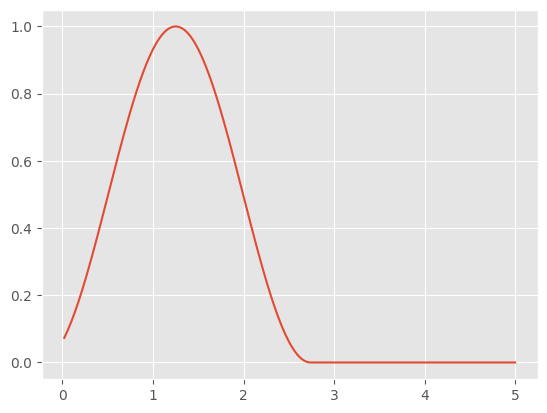

In [ ]:
# Create perturbation timeseries and interpoulate/perturb
alpha_vec = np.zeros(emas[f1_idx].shape[0])
# [print(e.shape) for e in emas]

# for interpolations --------
vowel_onset_time = 0.5
vowel_duration = 1.5 # for pIYk and pUWk
vowel_nucleus = vowel_onset_time + vowel_duration/2


pert_dur  = vowel_duration
pert_times = [vowel_nucleus]
window = np.hanning(round(pert_dur * (FS_SPARC_CODE) * 2))
idxs = [np.argmin(abs(emas_time[f1_idx] - t)) for t in pert_times]
alpha_vec[idxs] = alpha
alpha_vec = np.convolve(alpha_vec, window, 'same')
alpha_vec = alpha_vec[:, np.newaxis]  # shape becomes (128, 1)

e_out = np.multiply((1-alpha_vec), (emas[f1_idx]))  +     np.multiply(alpha_vec, (emas[f2_idx]))


# # for pertubations ----------
# pert_dur = 0.1
# window = np.hanning(round(pert_dur * (FS_SPARC_CODE) * 2))


# # perturb at multiple points
# pert_times = [0.5, 0.9]
# idxs = [np.argmin(abs(emas_time[f1_idx] - t)) for t in pert_times]
# alpha_vec[idxs] = alpha

# pert_times = [0.7]
# idxs = [np.argmin(abs(emas_time[f1_idx] - t)) for t in pert_times]
# alpha_vec[idxs] = -alpha

# # (vowel_duration * (FS_SPARC_CODE))

# alpha_vec = np.convolve(alpha_vec, window, 'same')
# alpha_vec = alpha_vec[:, np.newaxis]  # shape becomes (128, 1)

# emas[f2_idx] = np.multiply(alpha_vec, (emas[f2_idx]))
# e_out = emas[f1_idx] + emas[f2_idx]

plt.plot(emas_time[f1_idx], alpha_vec)

In [ ]:
# Prepare data in large DF and then animate
e1 = pd.DataFrame(emas[f1_idx])
e1.columns = mngu_channels
e1["series"] = "original"
e1["time"] = np.arange(e1.shape[0]) / FS_SPARC_CODE

e2 = pd.DataFrame(emas[f2_idx])
e2.columns = mngu_channels
e2["series"] = "perturbed"
e2["time"] = np.arange(e2.shape[0]) / FS_SPARC_CODE


e3 = pd.DataFrame(e_out)
e3.columns = mngu_channels
e3["series"] = "out"
e3["time"] = np.arange(e3.shape[0]) / FS_SPARC_CODE


df_ema = pd.concat([e1, e2, e3])
df_ema = df_ema.sort_values(by='time')
# df_ema = df_ema.iloc[,]
df_ema

sensor_neutral = [
    [5.4407711, -0.27898258],
    [3.9024611, 0.090298139],
    [2.2748213, -0.49493390],
    [0.82840538, -2.8019209],
    [-1.0039096, -0.083905414],
    [-0.67326981, -2.5571942]
]

pert_string = '-'.join(['%0.2f' % t for t in pert_times])
suffix = f'alpha-{alpha}_pert-onset-{pert_string}'
fnametmp = f'{files[f1_idx][0:-4]}-w1-{w1}_w2-{w2}_{suffix}'

animate_ema(df_ema, f'{fnametmp}.mp4', sensor_neutral=sensor_neutral,colors={'original': 'black', 'perturbed': 'red', 'out':'blue'}, trail_length=1, interval=round(1000/FS_SPARC_CODE))




In [ ]:
# optionally insert 
e_out

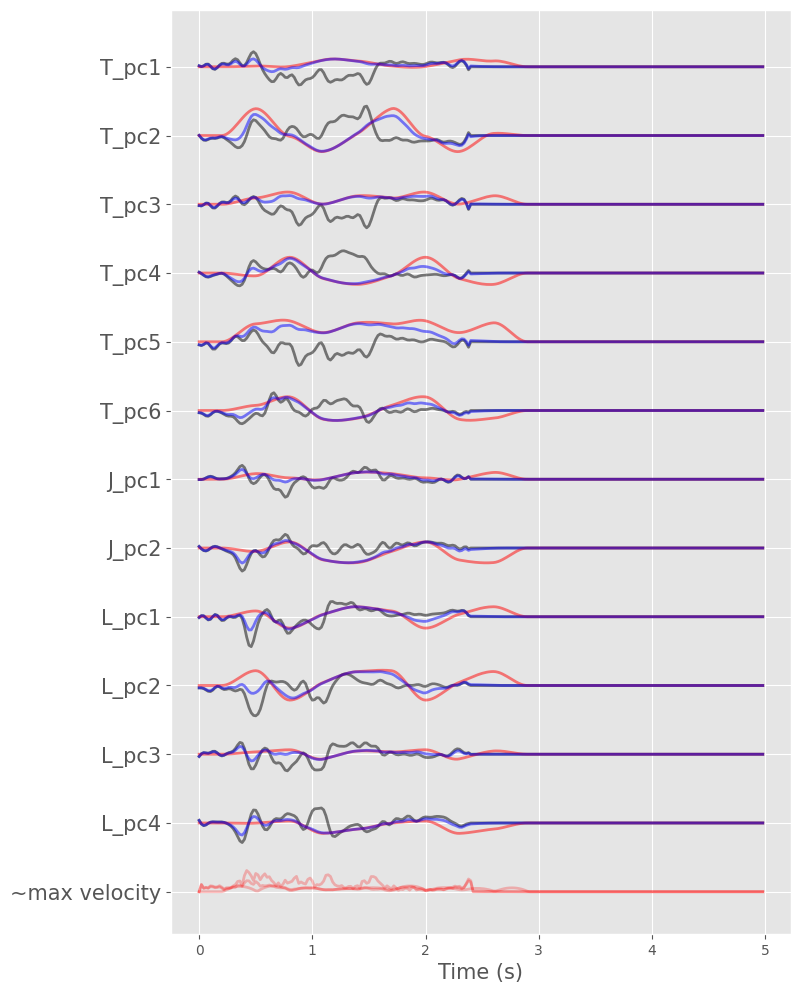

In [ ]:
# def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2, plot_velocity=False):
# emas_plot = [emas[f1_idx], emas[f2_idx], m2M(e_out.T, PC).T]
emas_plot = [emas[f1_idx], emas[f2_idx], e_out]
# emas_plot = [emas[f1_idx], emas[f2_idx], aroundtown['M'].T]
emas_plot_colors = ['k', 'r', 'b']

fig,ax = plt.subplots(1,1, figsize=(8,12), sharex=True)
# ax[0].plot(np.arange(0, wav.size) / wav_fs, wav)
for i, e in enumerate(emas_plot):
    e(ax, e, labels=labels_PC, color=emas_plot_colors[i], gap=8, alpha=0.5, lw=2)

# ax.legend(['orig', 'target', 'interp'])
# ax.set_xlim([0.5, 2])

In [ ]:
pert_string = '-'.join(['%0.2f' % t for t in pert_times])
suffix = f'alpha-{alpha}_pert-onset-{pert_string}'
fnametmp = f'{files[f1_idx][0:-4]}-w1-{w1}_w2-{w2}_{suffix}'

# suffix = f'alpha-{alpha}_pert-onset-{vowel_onset_time}'
code = codes[f1_idx].copy()
[print(k) for k in code.keys()]
[print(k, code[k].shape) for k in code.keys() if k in ['ema', 'acoustic_wvlm', 'pitch', 'periodicity', 'loudness']]

code['ema'] = e_out[np.arange(emas_orig[f1_idx].shape[0]), :]

# CAREFUL--are we already in PC space or not? 
# code['ema'] = M2m(code['ema'].T, PC).T

code['ema'] = code['ema'][np.newaxis, :]



wav = coder.decode(**code)
print(f'Duration: {len(wav) / coder.sr}')
# fnametmp = f'{files[f1_idx][0:-4]}-w1-{w1}_w2-{w2}_{suffix}.wav'
print(fnametmp)
sf.write(f'{fnametmp}.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

wav
ema
acoustics_wvlm
loudness
pitch
periodicity
pitch_stats
spk_emb
ft_len
ema (1, 120, 12)
loudness (1, 121, 1)
pitch (1, 120, 1)
periodicity (1, 120, 1)
Duration: 2.4
/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pIYk_aligned-w1-pIYk_w2-aroundtown_alpha-1_pert-onset-1.25


# SPARC helper functions

In [ ]:
def analyse_file(filename, target=None):
    # filename is the name of a wav file. in this function, we want to analyse the file and return sparc ema traces, MFCCs, and a spectrogram

    # target is an object that has already had target = analyse_file(target_filename). 
    # if target is not None, we will attempt to warp the file to 
    # f = '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pAHk_aligned.wav'
    # f = Path('/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/pAHk_aligned.wav')

    # (filepath.parent / (filepath.stem + "_resynth" + filepath.suffix))
    # f = folder / "never-stole_she.wav"

    f = Path(filename)


    c = {}
    # c["code_orig"] = copy.deepcopy(codes[0])
    c["code_orig"] = coder.encode(f)
    # resynthesize
    wav = coder.decode(**c["code_orig"])
    sf.write((f.parent / (f.stem + "_resynth" + f.suffix)), wav, coder.sr)

    c["fname"] = f.stem
    c["loudness"] = np.squeeze(c["code_orig"]['loudness'])
    c["ema"] = np.squeeze(c["code_orig"]['ema']) 
    c["pitch"] = np.squeeze(c["code_orig"]['pitch']) 
    c["periodicity"] = np.squeeze(c["code_orig"]['periodicity']) 

    c["time"] = np.arange(1, c["ema"].shape[0]+1) / FS_SPARC_CODE  

    # # Trim to equal length if needed (e.g., remove last sample)
    # if loudness is not None and loudness.shape[0] == ema.shape[0] + 1:
    #     loudness = loudness[:-1]
    # Assume: ema (T1, D), pitch (T2,), loudness (T3,)
    T = max(c["ema"].shape[0],
        c["pitch"].shape[0] if c["pitch"] is not None else 0,
        c["loudness"].shape[0] if c["loudness"] is not None else 0)
    if c["ema"].shape[0] < T:
        pad_width = ((0, T - c["ema"].shape[0]), (0, 0))
        c["ema"] = np.pad(c["ema"], pad_width, mode='edge')
    for feat in ["pitch", 'loudness', 'periodicity', 'time']:     
        if c[feat] is not None and c[feat].shape[0] < T:
            c[feat] = np.pad(c[feat], (0, T - c[feat].shape[0]), mode='edge')
    # if c["loudness"] is not None and c["loudness"].shape[0] < T:
    #     c["loudness"] = np.pad(c["loudness"], (0, T - c["loudness"].shape[0]), mode='constant')
    # if c["periodicity"] is not None and c["periodicity"].shape[0] < T:
    #     c["periodicity"] = np.pad(c["periodicity"], (0, T - c["periodicity"].shape[0]), mode='constant')

    # [print(k, c[k].shape) for k in c.keys() if k in ['ema', 'acoustic_wvlm', 'pitch', 'periodicity', 'loudness', 'time']]
    
    c["ema_pc"] = m2M(c["ema"].T, PC).T # convert from raw EMA sensors to EMA-principle components space



    # ------ 
    # Load audio and compute MFCCs
    c["wav"], c["wav_fs"] = librosa.load(f, sr=None)
    dur  = c["wav"].shape[0] / c["wav_fs"] 


    c["mfcc"] = librosa.feature.mfcc(y=c["wav"], sr=c["wav_fs"], n_mfcc=13)
    c["mfcc_time"] = (np.arange(0, c["mfcc"].shape[1]) / c["mfcc"].shape[1] * dur).squeeze()
    c["mfcc_delta"]= librosa.feature.delta(c["mfcc"].T)

    c["specgram"] = librosa.feature.melspectrogram(y=c["wav"], sr=c["wav_fs"], n_mels=128, fmax=8000)
    c["specgram_time"] = (np.arange(0, c["specgram"].shape[1]) / c["specgram"].shape[1] * dur).squeeze()

    c["mfcc"] = c["mfcc"].T
    c["specgram"] = c["specgram"].T

    # warp to target
    if target: 
        params = {
        "lambda_cum": 0.05, 
        "lambda_inst": 0.05,
        "Loss": "cosine"
        }

        # print('input shapes: ', c["mfcc_delta"].T.shape, target["mfcc_delta"].T.shape)
        [phi, mfcc2_warped, cost, g] = gdtw.warp(c["mfcc_delta"], target["mfcc_delta"], params=params)

        t = np.linspace(0, 1, len(target["specgram_time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values

        # Step 3: Interpolate follower spectrogram at warped times using linear interpolation
        S2_interp_func = interp1d(c["specgram_time"], c["specgram"], axis=0, bounds_error=False, fill_value=0)
        S2_warped = S2_interp_func(tau_sec)  # shape: (n_mels, N)
        # print(S2_warped.shape)

        c["warped"] = {}
        c["warped"]["phi"] = phi
        c["warped"]["fname"] = c["fname"] + "_warpto-" + target["fname"]
        # keys = ['code_orig', 'loudness', 'ema', 'pitch', 'periodicity', 'time', 'wav', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time']

        t = np.linspace(0, 1, len(target["time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values
        c["warped"]["time"] = target["time"]
        for feat in ['ema', 'ema_pc', 'loudness', 'pitch', 'periodicity']: 
            interp_func = interp1d(c["time"], c[feat], axis=0, bounds_error=False, fill_value=np.mean(c[feat]))
            c["warped"][feat] = interp_func(tau_sec)  # shape: (n_mels, N)


        t = np.linspace(0, 1, len(target["mfcc_time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values
        c["warped"]["mfcc_time"] = target["mfcc_time"]
        for feat in ['mfcc', 'mfcc_delta']: 
            interp_func = interp1d(c["mfcc_time"], c[feat], axis=0, bounds_error=False, fill_value=0)
            c["warped"][feat] = interp_func(tau_sec)  # shape: (n_mels, N)

        t = np.linspace(0, 1, len(target["specgram_time"]))   # normalized leader time
        tau = np.clip(np.array([phi(ti) for ti in t]), 0, 1)  # normalized follower time
        tau_sec = tau * dur # scale time values
        c["warped"]["specgram_time"] = target["specgram_time"]
        for feat in ['specgram']: 
            interp_func = interp1d(c["specgram_time"], c[feat], axis=0, bounds_error=False, fill_value=0)
            c["warped"][feat] = interp_func(tau_sec)  # shape: (n_mels, N)


        # resynthesize with warped 
        rs = {} # resynth
        rs["ema"] = c["warped"]['ema'][np.newaxis, :, :]
        rs["loudness"] = c["warped"]['loudness'][np.newaxis, :, np.newaxis]
        rs["pitch"] = c["warped"]['pitch'][np.newaxis, :, np.newaxis]
        rs["periodicity"] = c["warped"]['periodicity'][np.newaxis, :, np.newaxis]
        rs["spk_emb"] = c["code_orig"]['spk_emb'].copy()
        wav = coder.decode(**rs)
        sf.write((f.parent / (f.stem + "_warpto-" + target['fname'] + "_resynth" + f.suffix)), wav, coder.sr)
    return c


In [ ]:
def ensure_2d(x):
    return x[:, np.newaxis] if x.ndim == 1 else x

def apply_perturbation(code, perturbations, fs=50, sigma=3, coder=None, PC=PC):
    """
    Apply smooth temporal perturbations to a SPARC speech code object and synthesize audio.

    Parameters:
    - code: dict, the base speech code
    - perturbations: list of dicts, each describing a perturbation:
        {
            "feature": str, e.g. "ema", "ema_pc", "pitch", "loudness", "periodicity"
            "dim": int, index of the dimension to perturb
            "time": float, center of the perturbation window (in seconds)
            "magnitude": float, optional (for additive or absolute perturbation)
            "mode": "add" | "set" | "interpolate"
            "target_code": optional dict, only for "interpolate"
            "window": float, optional window duration in seconds (default determined by sigma)
        }
    - fs: int, sampling frequency of the signals
    - sigma: float, standard deviation for Gaussian smoothing in samples
    - coder: coder object with .decode() method (optional, for resynthesis)

    Returns:
    - code with a new code["pert"] dictionary
    """
    from scipy.ndimage import gaussian_filter1d
    import numpy as np

    pert = {}
    T = code["ema"].shape[0]

    # Clone original features
    for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
        if key in code:
            pert[key] = np.copy(code[key])

    time = code["time"]
    perturb_descriptions = []

    for p in perturbations:
        feature = p["feature"]
        dim = p["dim"]
        t0 = p["time"]
        mode = p.get("mode", "add")
        window = p.get("window", None)
        target_code = p.get("target_code", None)
        magnitude = p.get("magnitude", None)

        if mode is not "dilate" and feature not in pert:
            raise ValueError(f"Feature '{feature}' not in code")

        idx = np.argmin(np.abs(time - t0))

        impulse = np.zeros(T)
        impulse[idx] = 1.0
        if window:
            sigma_local = window * fs / 6  # 99.7% of Gaussian within ±3σ
        else:
            sigma_local = sigma

        smooth_envelope = gaussian_filter1d(impulse, sigma=sigma_local)
        smooth_envelope = smooth_envelope / smooth_envelope.max()

        if mode == "add":
            if feature in ['ema', 'ema_pc']: 
                base = (pert[feature])[:, dim]
                pert[feature][:, dim] = base + magnitude * smooth_envelope
            else: 
                # base = (pert[feature])[:, dim]
                pert[feature] += magnitude * smooth_envelope
            description = f"{feature}{dim}@{t0:.1f}s_+{magnitude:.2f}"
        elif mode == "set":
            if feature in ['ema', 'ema_pc']: 
                base = (pert[feature])[:, dim]
                pert[feature][:, dim] = base * (1 - smooth_envelope) + magnitude * smooth_envelope                
            else: 
                pert[feature] = pert[feature] * (1 - smooth_envelope) + magnitude * smooth_envelope           
            
            description = f"{feature}{dim}@{t0:.1f}s_set{magnitude:.2f}"
        elif mode == "interpolate":
            
            if target_code is None:
                raise ValueError("interpolate mode requires 'target_code'")
            target_feat = target_code[feature][:, dim]
            base = pert[feature][:, dim]
            pert[feature][:, dim] = base * (1 - smooth_envelope) + target_feat * smooth_envelope
            description = f"{feature}{dim}@{t0:.1f}s_interp"
        elif mode == "dilate":
            # Create a time-warping map for this window
            dilation = magnitude  # >1 lengthen, <1 shorten
            # t_start = t0 - window / 2
            # t_end = t0 + window / 2
            # mask = (time >= t_start) & (time <= t_end)
            # warped_time = np.copy(time)
            # warped_time[mask] = t_start + (time[mask] - t_start) / dilation

            tt = np.diff(time, prepend=0) + np.diff(time, prepend=0)*(dilation*smooth_envelope)
            warped_time = np.cumsum(tt)
            warptime2ogtime = interp1d(warped_time, time, bounds_error=False, fill_value=0)

            time_new_linear = np.arange(0, warped_time.max()+0.001, 1/FS_SPARC_CODE)


            for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
                if key not in pert:
                    continue
                y = pert[key]
                if y.ndim == 1:
                    interp = interp1d(time, y, bounds_error=False, fill_value=0)
                    pert[key] = interp(warptime2ogtime(time_new_linear))
                else:
                    interp = interp1d(time, y, axis=0, bounds_error=False, fill_value=0)
                    pert[key] = interp(warptime2ogtime(time_new_linear))
            description = f"{feature}@{t0:.1f}s_dilatex{dilation:.2f}"
            pert['time'] = time_new_linear
        else:
            raise ValueError(f"Unknown mode: {mode}")

        perturb_descriptions.append(description)

        if feature=="ema" and PC is not None: 
            pert["ema_pc"] = m2M(pert["ema"].T, PC).T
        elif feature=="ema_pc" and PC is not None:
            pert["ema"] = M2m(pert["ema_pc"].T, PC).T


    # Construct filename
    pert["fname"] = code["fname"] + "_pert_" + "-".join(perturb_descriptions)

    # Optional: synthesize perturbed audio
    if coder is not None:
        resynth_input = {
            "ema": pert["ema"][np.newaxis, :, :],
            "loudness": pert["loudness"][np.newaxis, :, np.newaxis],
            "pitch": pert["pitch"][np.newaxis, :, np.newaxis],
            "periodicity": pert["periodicity"][np.newaxis, :, np.newaxis],
            "spk_emb": code["code_orig"]["spk_emb"].copy()
        }
        wav = coder.decode(**resynth_input)
        pert["wav"] = wav

    code["pert"] = pert
    return code


<>:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/scratch/162339.1.onrcc-gpu/ipykernel_942117/2479848239.py:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if mode is not "dilate" and feature not in pert:


# Prosodic differences in trajectories

In [ ]:

folder = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/never-stole")
# folder = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/")

# (filepath.parent / (filepath.stem + filepath.suffix)).exists()
# f = folder / "dict_short.wav"
# target = analyse_file(f)

f = folder / "never-stole_said.wav"
c = analyse_file(f, target)




In [ ]:
c = target
c["time"]
np.arange(0, 2.84+0.001, 1/FS_SPARC_CODE)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  , 2.02, 2.04, 2.06, 2.08, 2.1 , 2.12, 2.14, 2.16, 2.18,
       2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 ,
       2.42, 2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56, 2.58, 2.6 , 2.62,
       2.64, 2.66, 2.68, 2.7 , 2.72, 2.74, 2.76, 2.78, 2.8 , 2.82, 2.84])

In [ ]:

perturbations = [
# {"feature": "ema_pc", "dim": 6, "time": 1.3, "window": 1,  "magnitude": 2, "mode": "add"},
# {"feature": "pitch", "dim": 0, "time": 1, "window": 1,  "magnitude": 10,  "mode": "add"}, 
# {"feature": "pitch", "dim": 0, "time": 2, "window": 2,  "magnitude": 50,  "mode": "add"}, 
{"feature": "pitch", "dim": 0, "time": 1, "window": 0.5,  "magnitude": 30,  "mode": "add"},
{"feature": "loudness", "dim": 0, "time": 1, "window": 0.5,  "magnitude": 1,  "mode": "add"}, 
{"feature": "", "dim": 0, "time": 1, "window": 0.5,  "magnitude": 1.3,  "mode": "dilate"}
# {"feature": "pitch", "dim": 0, "time": 1.6, "mode": "interpolate", "target_code": target_code}
]
# 0.8 for "never"
# 1.3 for "said"

c = apply_perturbation(c, perturbations, fs=50, sigma=3, coder=coder, PC=PC)
sf.write(folder / (c["pert"]["fname"] + ".wav"), c['pert']['wav'], coder.sr)
ipd.display(ipd.Audio(c['pert']['wav'], rate=coder.sr))



c_plot = [c, c['pert']]
c_plot_colors = ['r', 'g', 'b']

# Plot and save
fig, ax = plt.subplots(figsize=(12, 8))
for i, code in enumerate(c_plot):
    # _, fname = os.path.split(files[i])
    fname = code['fname']
    plot_art(
        ax, code["ema"], # ema, ema_pc
        labels=hprc_channels, # hprc_channels, labels_PC
        color=c_plot_colors[i],
        series_name=fname, 
        gap=7, alpha=0.5, lw=2,
        pitch= sp.stats.zscore(code['pitch']), # sp.stats.zscore .... pitches[i], # pitches[i],
        loudness= sp.stats.zscore(code['loudness']), 
        periodicity= sp.stats.zscore(code['periodicity'])
    )

Text(0.5, 1.0, 'Follower (Warped)')

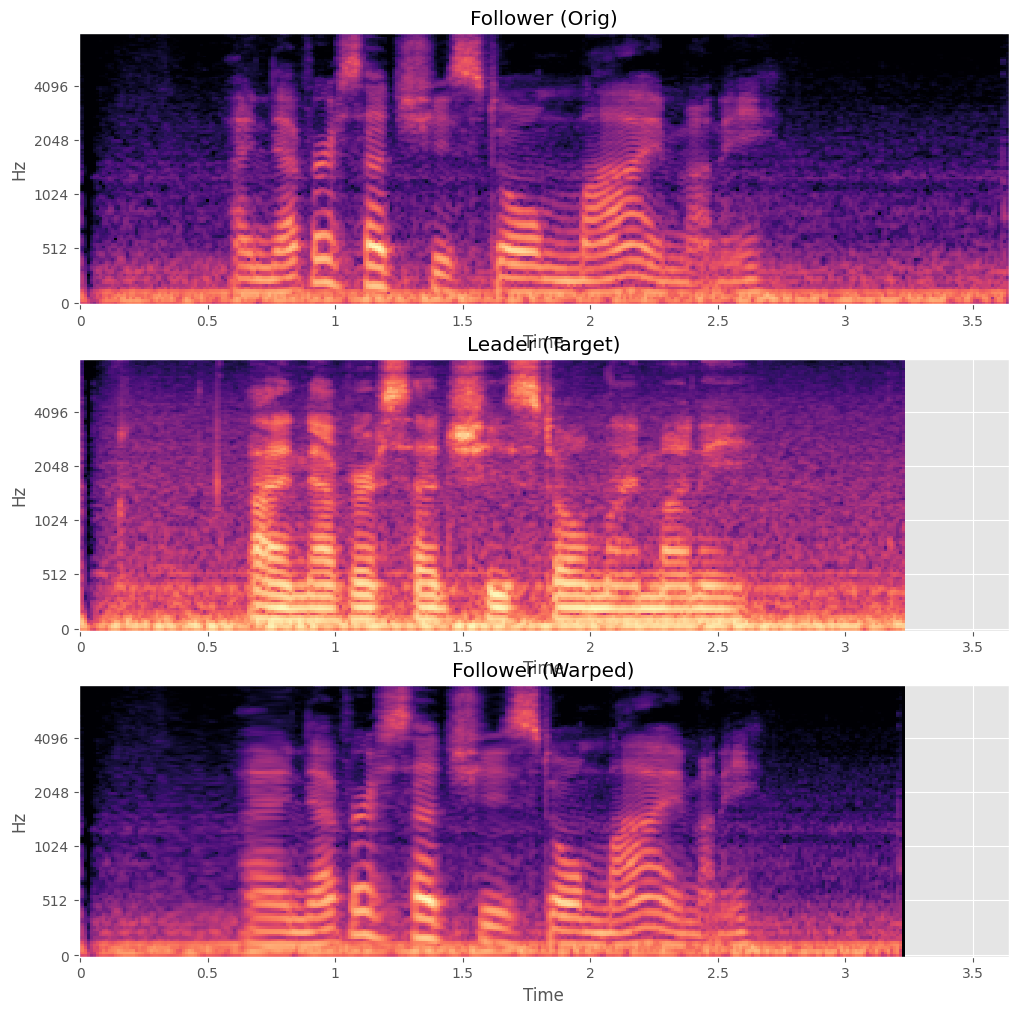

In [ ]:

# Step 4: Plot
fig = plt.figure(figsize=(12, 12))

# Top: warped follower spectrogram
ax_top = fig.add_subplot(311)
librosa.display.specshow(librosa.power_to_db(c_plot[0]["specgram"].T, ref=np.max),
                         sr=c_plot[0]["wav_fs"], x_axis='time', y_axis='mel', fmax=8000, 
                         ax=ax_top)
ax_top.set_title("Follower (Orig)")
# ax_top.label_outer()

# Middle: leader spectrogram
ax_mid = fig.add_subplot(312, sharex=ax_top)
librosa.display.specshow(librosa.power_to_db(c_plot[1]["specgram"].T, ref=np.max),
                         sr=c_plot[0]["wav_fs"], x_axis='time', y_axis='mel', fmax=8000, 
                         ax=ax_mid)
ax_mid.set_title("Leader (Target)")
# ax_mid.label_outer()

# Bottom: original follower spectrogram
ax_bot = fig.add_subplot(313, sharex=ax_top)
librosa.display.specshow(librosa.power_to_db(c_plot[2]["specgram"].T, ref=np.max),
                         sr=c_plot[0]["wav_fs"], x_axis='time', y_axis='mel', fmax=8000, 
                         ax=ax_bot)
ax_bot.set_title("Follower (Warped)")

['/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/BOB2-bought-dog_bob-aligned.wav', '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/bob-BOUGHT2-dog_bob-aligned.wav', '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/bob-bought-DOG2_bob-aligned.wav']


/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
['/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/BOB2-bought-dog_bought-aligned.wav', '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/bob-BOUGHT2-dog_bought-aligned.wav', '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/bob-bought-DOG2_bought-aligned.wav']


/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
['/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/BOB2-bought-dog_dog-aligned.wav', '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/bob-BOUGHT2-dog_dog-aligned.wav', '/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/audio-aligned-bob/bob-bought-DOG2_dog-aligned.wav']


/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4
_extract_ema: v4
_extract_ema: v4


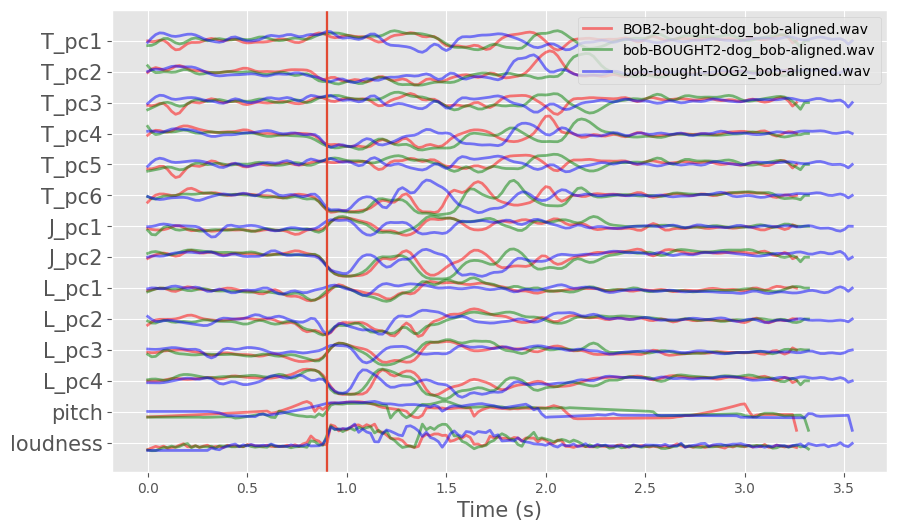

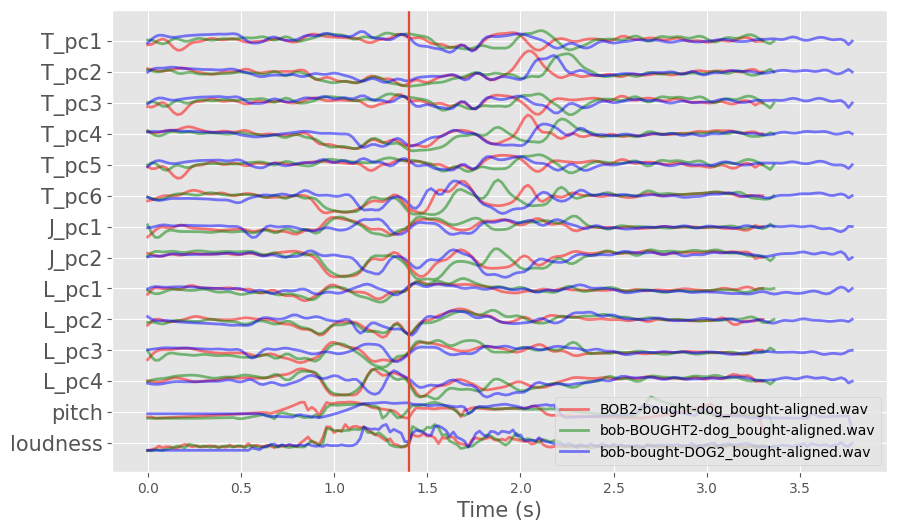

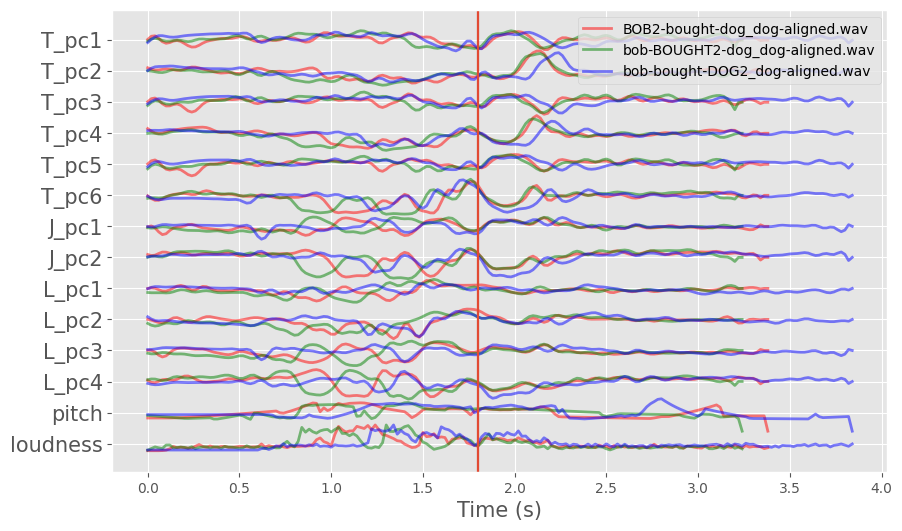

In [ ]:
# def plot_prosody_aligned_trajectories(coder, PC, labels_PC, output_dir, topdir):
"""
Process and plot articulator trajectories from a set of aligned .wav files
showing how prosody affects movement across alignments.

Parameters:
- coder: object with .encode() and .decode() methods
- PC: principal components (for projection)
- labels_PC: list of labels for PC dimensions
- output_dir: where to save the resulting plots
- topdir: root directory containing the sample_audio folder
"""
import glob
from pathlib import Path


topdir = "/projectnb/busplab/lbullock/sparc_sample_audio/"

folder = Path(topdir) / "sample_audio" / "audio-aligned-bob"
alignment_types = ['bob', 'bought', 'dog']
alignment_times = [0.9, 1.4, 1.8]
emas_plot_colors = ['r', 'g', 'b']

for ialign, align in enumerate(alignment_types):
    files = sorted(glob.glob(str(folder / f"*_{align}-aligned.wav")))
    print(files)

    emas_plot = []
    pitches = []
    loudnesses = []

    def zscore_and_scale_to_max3(x):
        if x is None:
            return None
        x = (x - np.mean(x)) / np.std(x)  # z-score
        max_abs = np.max(np.abs(x))
        if max_abs > 0:
            x = x * (3.0 / max_abs)
        return x

    # Apply to pitch and loudness
    pitch = zscore_and_scale_to_max3(pitch)
    loudness = zscore_and_scale_to_max3(loudness)

    for f in files:
        # Use coder.encode to extract data
        code = coder.encode(f)
        ema = np.squeeze(code['ema'])  # (T, D)
        pitch = np.squeeze(code['pitch']) if 'pitch' in code else None
        loudness = np.squeeze(code['loudness']) if 'loudness' in code else None

        # # Trim to equal length if needed (e.g., remove last sample)
        # if loudness is not None and loudness.shape[0] == ema.shape[0] + 1:
        #     loudness = loudness[:-1]
        # Assume: ema (T1, D), pitch (T2,), loudness (T3,)
        T = max(ema.shape[0],
                pitch.shape[0] if pitch is not None else 0,
                loudness.shape[0] if loudness is not None else 0)
        if ema.shape[0] < T:
            pad_width = ((0, T - ema.shape[0]), (0, 0))
            ema = np.pad(ema, pad_width, mode='constant')
        if pitch is not None and pitch.shape[0] < T:
            pitch = np.pad(pitch, (0, T - pitch.shape[0]), mode='constant')
        if loudness is not None and loudness.shape[0] < T:
            loudness = np.pad(loudness, (0, T - loudness.shape[0]), mode='constant')

        pitch = zscore_and_scale_to_max3(pitch)
        loudness = zscore_and_scale_to_max3(loudness)


        # Project to PC space if needed
        # ema_pc = m2M(ema.T, PC).T  # shape: (T, num_PC) aroundtown['m'] = M2m(aroundtown['M'].T, PC).T
        ema_pc = ema

        emas_plot.append(ema_pc)
        pitches.append(pitch)
        loudnesses.append(loudness)

    # Plot and save
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, e in enumerate(emas_plot):
        _, fname = os.path.split(files[i])

        plot_art(
            ax, e,
            labels=labels_PC,
            color=emas_plot_colors[i],
            series_name=fname, 
            gap=5, alpha=0.5, lw=2,
            pitch= pitches[i], # pitches[i], # pitches[i],
            loudness=loudnesses[i]
        )
        ax.axvline(alignment_times[ialign])
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=10)

    # Save figure
    fig_path = Path(folder) / f"trajectories_ema_{align}.png"
    fig.savefig(fig_path)
    
    # plt.close(fig)

    # return f"Plots saved to {output_dir}"


['bob-bought-DOG2', 'bought-aligned.wav']

# Utterance synthesis from word dictionary

In [ ]:

from scipy.interpolate import interp1d

FS_SPARC_CODE = 50  # Hz


def build_word_dictionary(wav_filename, textgrid_filename, margin_sec=0.5):
    wav_path = Path(wav_filename)
    tg = textgrid.TextGrid.fromFile(textgrid_filename)
    word_tier = [tier for tier in tg.tiers if tier.name.lower() == "word"]
    assert len(word_tier) == 1, "TextGrid must contain a 'word' tier"
    word_tier = word_tier[0]

    y, sr = sf.read(wav_filename)
    word_dict = {}

    for interval in word_tier.intervals:
        label = interval.mark.strip().lower()
        if label == "":
            continue

        start = max(0, interval.minTime - margin_sec)
        end = min(interval.maxTime + margin_sec, len(y) / sr)

        y_segment = y[int(start * sr): int(end * sr)]
        tmp_wav_path = wav_path.parent / f"tmp_{label}_{int(start*1000)}ms.wav"
        sf.write(tmp_wav_path, y_segment, sr)

        c = analyse_file(tmp_wav_path)
        c['start_time'] = start
        c['end_time'] = end

        entry = {
            'sparc': {k: c[k] for k in ["ema", "pitch", "periodicity", "loudness", "time"]},
            'fs': sr,
            'start_time': start,
            'end_time': end,
            'fname': tmp_wav_path.name
        }

        word_dict.setdefault(label, []).append(entry)

    return word_dict

def synth_from_word_dictionary(
    utterance_string, word_dict, coder, spk_emb=None,
    smooth=True, crossfade=0.1, margin_sec=0.5,
    perturbations=None, apply_perturbation_fn=None
):
    """
    Concatenates SPARC codes for a given utterance using word_dict entries,
    trims margins, applies optional smoothing and stress-based perturbations,
    and returns waveform from coder.decode().

    Parameters:
    - utterance_string : str (e.g., "buy0 the0 cat1")
    - word_dict : dict
    - coder : model with .decode() method
    - spk_emb : optional speaker embedding
    - smooth : bool
    - crossfade : float, seconds of overlap smoothing
    - margin_sec : float, how much margin to trim from beginning/end
    - perturbations : list, one entry per stressed word (or None)
    - apply_perturbation_fn : callable, function to apply perturbation (required if perturbations is used)

    Returns:
    - dict with keys: code, wav, fname
    """
    import re
    from scipy.ndimage import zoom

    FS_SPARC_CODE = 50  # assumed global

    default_pert_template = [
        {"feature": "pitch", "dim": 0, "time": None, "window": None, "magnitude": 30, "mode": "add"},        
        {"feature": "loudness", "dim": 0, "time": None, "window": None, "magnitude": 1, "mode": "add"},
        {"feature": "", "dim": 0, "time": None, "window": None, "magnitude": 1.3, "mode": "dilate"},
    ]

    words = utterance_string.strip().split()
    word_specs = []
    for w in words:
        match = re.match(r"(\w+?)([01]?)$", w)
        if match:
            word = match.group(1).lower()
            stress = int(match.group(2)) if match.group(2) != '' else 0
            word_specs.append((word, stress))
        else:
            raise ValueError(f"Could not parse word/stress from token: '{w}'")

    code = {"ema": [], "pitch": [], "loudness": [], "periodicity": [], "time": []}
    time_offset = 0
    gap_frames = int(FS_SPARC_CODE * crossfade)
    margin_frames = int(FS_SPARC_CODE * margin_sec)
    stressed_durations = []

    for word, stress in word_specs:
        assert word in word_dict, f"Word '{word}' not in dictionary"
        entry = word_dict[word][0]

        segs = {}
        for key in ["ema", "pitch", "loudness", "periodicity", "time"]:
            seg = entry['sparc'][key]
            if seg.shape[0] > 2 * margin_frames:
                seg = seg[margin_frames:-margin_frames]
            segs[key] = seg

        t = segs['time']
        t = t - t[0] + time_offset
        segs['time'] = t
        word_duration = t[-1] - t[0]

        if stress == 1:
            stressed_durations.append((time_offset, word_duration))

        for key in ["ema", "pitch", "loudness", "periodicity"]:
            seg = segs[key]
            if smooth and len(code[key]) > 0:
                tail = code[key][-1][-gap_frames:]
                head = seg[:gap_frames]
                alpha = np.linspace(0, 1, gap_frames)[:, None]
                if tail.ndim == 1:
                    blended = (1 - alpha.squeeze()) * tail + alpha.squeeze() * head
                else:
                    blended = (1 - alpha) * tail + alpha * head
                code[key][-1] = np.vstack([code[key][-1][:-gap_frames], blended])
                seg = seg[gap_frames:]
            code[key].append(seg)

        code['time'].append(t)
        time_offset = t[-1] + 1 / FS_SPARC_CODE

    for k in code:
        code[k] = np.concatenate(code[k], axis=0)

    # Apply perturbations to stressed words
    if perturbations is not None and apply_perturbation_fn is not None:
        all_pert = []
        for i, (start_time, dur) in enumerate(stressed_durations):
            pert_list = perturbations[i] if perturbations[i] is not None else copy.deepcopy(default_pert_template)
            for p in pert_list:
                if p["time"] is None:
                    p["time"] = start_time + dur / 2
                if p["window"] is None:
                    p["window"] = dur
            # all_pert.extend(pert_list)
            code['fname'] = "_".join([w for w, _ in word_specs])
            code = apply_perturbation_fn(code, pert_list, fs=FS_SPARC_CODE, coder=None)
            code = code["pert"]
        final_code = code
    else:
        final_code = code

    resynth_input = {
        "ema": final_code["ema"][np.newaxis, :, :],
        "loudness": final_code["loudness"][np.newaxis, :, np.newaxis],
        "pitch": final_code["pitch"][np.newaxis, :, np.newaxis],
        "periodicity": final_code["periodicity"][np.newaxis, :, np.newaxis],
        "spk_emb": spk_emb if spk_emb is not None else np.zeros((1, 256))
    }
    wav = coder.decode(**resynth_input)

    return {"code": final_code, "wav": wav, "fname": "_".join([w for w, _ in word_specs])}




In [ ]:
# get speaker embedding
folder = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/")
f = folder / "dict_short.wav"
c = analyse_file(f)
spk_emb = c['code_orig']['spk_emb']

/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4


In [ ]:
# folder = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/never-stole")
folder = Path("/projectnb/busplab/lbullock/sparc_sample_audio/sample_audio/")

marg_sec = 0.5
dict_word = build_word_dictionary(folder / "dict_short.wav", folder / "dict_short.TextGrid", margin_sec=marg_sec)
dict_word.keys()

/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4
_extract_ema: v4


dict_keys(['the', 'puppy', 'jumped', 'on', 'a', 'couch', 'buy', 'bobby', 'she', 'saw', 'cat'])

In [ ]:
s = "bobby jumped cat bobby the couch1 cat"
perts = [None]
r = synth_from_word_dictionary(s, dict_word, coder, spk_emb=spk_emb, smooth=False, crossfade=0.1, margin_sec=marg_sec, perturbations=perts, apply_perturbation_fn=apply_perturbation)
# sf.write((f.parent / (f.stem + "_warpto-" + target['fname'] + "_resynth" + f.suffix)), wav, coder.sr)


sf.write(folder / ('resynth-from-dict_' + s +'.wav'), r['wav'], coder.sr)
ipd.display(ipd.Audio(r['wav'], rate=coder.sr))



# Voice Conversion

In [ ]:
# src_wav_file = '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav' # '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav'
# src_wav_file = '../sample_audio/sub-DM1033_ses-intraop_task-lombard_run-03_directionalmicaec-start-99s.wav'
src_wav_file = '../sample_audio/thisisme-lat.wav'

# targspkemb_wav_file = '../sample_audio/be2d-chin-trim.wav'
targspkemb_wav_file = '../sample_audio/thisisme-fran.wav'


In [ ]:
converted_wav = coder.convert(src_wav_file, targspkemb_wav_file)
ipd.display(ipd.Audio(converted_wav, rate=coder.sr))

sf.write(src_wav_file[0:-4] + '_voice-from_' + os.path.split(targspkemb_wav_file)[1][0:-4]  + '-resynth.wav', converted_wav, coder.sr)


In [ ]:
src_code = coder.encode(src_wav_file)

In [ ]:
converted_code = coder.encode(converted_wav)

In [ ]:
# Articulatory traces remain consistent after voice conversion.
plt.plot(src_code['ema'][:,5])
plt.plot(converted_code['ema'][:,5])

In [ ]:
# source audio
src_wav,sr = sf.read(src_wav_file)
ipd.display(ipd.Audio(src_wav, rate=sr))

In [ ]:
# target audio
trg_wav,sr = sf.read(targspkemb_wav_file)
ipd.display(ipd.Audio(trg_wav, rate=sr))

# Unseen Language

In [ ]:
wav_file = "../sample_audio/italian.wav"

In [ ]:
code = coder.encode(wav_file)

In [ ]:
wav = coder.decode(**code)

In [ ]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))